In [1]:
import torch

torch.manual_seed(9527)

if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator()
else:
    device = torch.device("cpu")

In [2]:
from time import perf_counter, ctime
from datetime import timedelta


def train(model, dataloader, backward, epochs=20):
    losses, *_ = [], model.to(device).train()
    label, start_time = model.__class__.__name__, perf_counter()
    print(f"{label} @ {ctime()}\n")
    for epoch in range(epochs):
        total_loss, start = 0, perf_counter()
        for source, target in dataloader:
            source, target = source.to(device), target.to(device)
            logits = model(source, target[:, :-1])
            loss = backward(logits.view(-1, logits.size(-1)), target[:, 1:].reshape(-1))
            loss = loss.cpu().item()
            losses.append(loss)
            total_loss += loss
        print(
            f"Epoch {epoch+1:>2}/{epochs}, Time {timedelta(seconds=int(perf_counter()-start))}, Loss {total_loss / len(dataloader)}"
        )
    print(f"\n{label} # {timedelta(seconds=int(perf_counter() - start_time))}\n")
    return losses


@torch.no_grad()
def eval(model, dataloader, print_result, max_len, bos):
    model.to(device).eval()
    for x, Y in dataloader:
        x, y = x.to(device), torch.full((1, 1), bos, dtype=int, device=device)
        for _ in range(max_len - 1):
            logits = model(x, y).argmax(dim=-1)
            y = torch.concat([y, logits[:, -1:]], dim=-1)
            if y[0, -1].item() == bos:
                break
        print_result(
            [index for index in x.view(-1).tolist() if index > 2],
            [index for index in Y.view(-1).tolist() if index > 2],
            [index for index in y.view(-1).tolist() if index > 2],
        )

Transformer @ Mon Sep  8 18:11:26 2025

Epoch  1/20, Time 0:00:36, Loss 2.4044268717754895
Epoch  2/20, Time 0:00:40, Loss 1.3915997533558162
Epoch  3/20, Time 0:00:40, Loss 1.0176750459714667
Epoch  4/20, Time 0:00:36, Loss 0.7828266638367345
Epoch  5/20, Time 0:00:34, Loss 0.6193557100656103
Epoch  6/20, Time 0:00:34, Loss 0.4968242787796518
Epoch  7/20, Time 0:00:34, Loss 0.40319462444471277
Epoch  8/20, Time 0:00:34, Loss 0.33209945288757436
Epoch  9/20, Time 0:00:35, Loss 0.2864462306011187
Epoch 10/20, Time 0:00:36, Loss 0.2473452924079426
Epoch 11/20, Time 0:00:36, Loss 0.21733393748578544
Epoch 12/20, Time 0:00:35, Loss 0.19720911355667856
Epoch 13/20, Time 0:00:36, Loss 0.18323743118301408
Epoch 14/20, Time 0:00:35, Loss 0.1685181004368195
Epoch 15/20, Time 0:00:35, Loss 0.15442173465131623
Epoch 16/20, Time 0:00:36, Loss 0.14999612350042407
Epoch 17/20, Time 0:00:35, Loss 0.1411473366604517
Epoch 18/20, Time 0:00:34, Loss 0.13400026064715614
Epoch 19/20, Time 0:00:34, Loss 0.

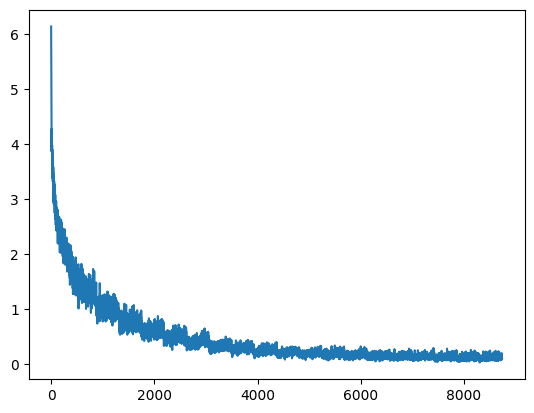

In [3]:
from dataset import get_dataset, cmn_words, eng_words, seq_len, bos
from model import Transformer
from torch import nn, optim

import matplotlib.pyplot as plt

train_loader, test_loader = get_dataset()
input_size, output_size = len(cmn_words) + 3, len(eng_words) + 3

model = Transformer(input_size, output_size, max_len=seq_len)
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)


def backward(logits, target):
    loss = loss_fn(logits, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss


losses = train(model, train_loader, backward)

plt.plot(losses)

In [4]:
def print_result(source, target, output):
    print("source:", " ".join(cmn_words[i - 3] for i in source))
    print("target:", " ".join(eng_words[i - 3] for i in target))
    print("output:", " ".join(eng_words[i - 3] for i in output))
    print()


eval(model, test_loader, print_result, seq_len, bos)

source: 您 想要 茶 还是 咖啡 ？
target: would you like tea or coffee ?
output: would you like tea or coffee ?

source: 那 是 一个 很 好 的 问题 。
target: that 's a good question .
output: that 's a good question .

source: 这 不是 一件 开玩笑 的 事 。
target: this is n't a joking matter .
output: this is not a very good time .

source: 我 在 树林 里 迷路 了 。
target: i got lost in the forest .
output: i got lost in the way .

source: 你 认为 如何 ?
target: what do you think of that ?
output: what do you think about that ?

source: 去 纽约 旅行 吧 ！
target: let 's take a trip to new york .
output: let 's take a new car !

source: 让 我们 去 野餐 。
target: let 's go to the picnic .
output: let 's go on a hurry .

source: 你 看起来 就 像 你 的 母亲 。
target: you look just like your mother .
output: you look just like your mother .

source: 你 来 这里 出差 的 ？
target: are you here on business ?
output: what did you come here for ?

source: 您 最 喜欢 什么 水果 ？
target: what fruit do you like the best ?
output: what do you like the best ?

source: 我 没 听懂 您 的 意思 。
ta